In [1]:
import os
import sys
import math
import datetime
import sc_utils
import tables            as tb
import numpy             as np
import pandas            as pd
import reco_functions    as rf
import analysis_utils    as ats
import matplotlib.pyplot as plt

import antea.database.load_db as db
from   antea.io.mc_io_tb                import read_SiPM_bin_width_from_conf
from   antea.io.mc_io_tb                import go_through_file
from   antea.io.mc_io_tb                import read_mcTOFsns_response
from   invisible_cities.io  .mcinfo_io  import read_mcinfo
from   invisible_cities.core.exceptions import SipmEmptyList

from   invisible_cities.icaro.hst_functions import hist
from   scipy           .stats               import norm
import invisible_cities.core .fit_functions as     fitf

In [20]:
start      = 10
numb       = 1
eventsPath = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/Christoff_sim/compton/analysis/data_ring'
file_name  = 'full_ring_iradius165mm_z140mm_depth3cm_pitch7mm'
base_path  = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/Christoff_sim/compton/analysis/'
data_path  = '4_data_crt_no_compton/'
identifier = 'irad165mm_depth3cm'

data_path  = f"{base_path}/{data_path}"
evt_file   = f"{data_path}/full_ring_{identifier}_crt_{start}_{numb}"

if identifier == 'irad165mm_d3cm_no_refl_sipms':
    rpos_threshold = 4
else:
    rpos_threshold = 3

phi_threshold  = 5
zpos_threshold = 4
e_threshold    = 2
r_int          = 165 #mm

rpos_file   = f"{base_path}/r_sigma_phi_table_{identifier}_thr{rpos_threshold}pes_no_compton.h5"
#Rpos        = ats.load_rpos(rpos_file, group="Radius", node=f"f{rpos_threshold}pes150bins")                                                                                      

if identifier == 'irad165mm_d3cm_no_refl_sipms':
    Rpos = ats.load_rpos(rpos_file, group="Radius", node=f"f4pes150bins")
else:
    Rpos = ats.load_rpos(rpos_file, group="Radius", node=f"f3pes150bins")

time_diff = []
pos_cart1 = []
pos_cart2 = []
event_ids = []

ave_speed_in_LXe = 0.210 # mm/ps 
speed_in_vacuum  = 0.299792458 # mm/ps

In [29]:
xs, ys, zs = [], [], []
sns_xs_t, sns_ys_t, sns_zs_t = [], [], []

idsss = []

for number in range(start, start+numb):
    number_str = "{:03d}".format(number)
    filename  = f"{eventsPath}/{file_name}.{number_str}.pet.h5"
    try:
        print('Trying file {0}'.format(filename))
        h5in = tb.open_file(filename, mode='r')
    except ValueError:
        continue
    except OSError:
         continue
    print('Analyzing file {0}'.format(filename))

    h5extents      = h5in.root.MC.extents
    events_in_file = len(h5extents)
    
    sens_pos       = rf.sensor_position    (h5in)
    sens_pos_cyl   = rf.sensor_position_cyl(h5in)
    bin_width      = read_SiPM_bin_width_from_conf(h5in)

    charge_range = (1000, 1400)

    #for evt in range(events_in_file):
    for evt in range(2502,2503):
        ave_true1, ave_true2 = rf.true_photoelect(h5in, filename, evt, compton=False)
        print(ave_true1, ave_true2)
        if len(ave_true1)==0 or len(ave_true2)==0:
            continue
            
        event_number       = h5in.root.MC.extents[evt]['evt_number']
        this_event_wvf     = go_through_file(h5in, h5in.root.MC.waveforms, (evt, evt+1), bin_width, 'data')
        this_event_wvf_tof = read_mcTOFsns_response(filename, (evt, evt+1))

        sns_over_thr, charges_over_thr = rf.find_SiPMs_over_threshold(this_event_wvf, e_threshold)

        if len(charges_over_thr) == 0: continue

        this_event_dict = read_mcinfo(h5in, (evt, evt+1))
        part_dict       = list(this_event_dict.values())[0]
        i1, i2, pos_true1, pos_true2, _, _, ids1, ids2, q1, q2, pos1, pos2 = rf.select_true_pos_from_charge(sns_over_thr, 
                                                                                                charges_over_thr, 
                                                                                                charge_range, 
                                                                                                sens_pos, part_dict)
        idsss.append(ids1)
        
        print(evt)
        if i1 and i2:
            positions1, qs1 = rf.reco_pos_single(pos_true1, np.array(q1), np.array(pos1), 
                                                  rpos_threshold, phi_threshold, zpos_threshold)
            positions2, qs2 = rf.reco_pos_single(pos_true2, np.array(q2), np.array(pos2), 
                                                  rpos_threshold, phi_threshold, zpos_threshold)

            if len(positions1) == 0 or len(positions2) == 0:
                continue

            phi1s       = ats.from_cartesian_to_cyl(positions1[0])[:,1]
            var_phi1    = rf.get_var_phi(phi1s, qs1[0])
            sigma_phi1  = np.sqrt(var_phi1)
            r1          = Rpos(sigma_phi1).value

            phi2s       = ats.from_cartesian_to_cyl(positions2[0])[:,1]
            var_phi2    = rf.get_var_phi(phi2s, qs2[0])
            sigma_phi2  = np.sqrt(var_phi2)
            r2          = Rpos(sigma_phi2).value

            reco_cart = ats.barycenter_3D(positions1[1], qs1[1])
            phi1      = np.arctan2(reco_cart[1], reco_cart[0])

            reco_cart = ats.barycenter_3D(positions2[1], qs2[1])
            phi2      = np.arctan2(reco_cart[1], reco_cart[0])

            reco_cart = ats.barycenter_3D(positions1[2], qs1[2])
            z1        = reco_cart[2]

            reco_cart = ats.barycenter_3D(positions2[2], qs2[2])
            z2        = reco_cart[2]
            
            pos1_cart = []
            pos2_cart = []
            if r1 and phi1 and z1 and len(q1) and r2 and phi2 and z2 and len(q2):
                pos1_cart.append(r1 * np.cos(phi1))
                xs.append(r1 * np.cos(phi1))
                pos1_cart.append(r1 * np.sin(phi1))
                ys.append(r1 * np.sin(phi1))
                pos1_cart.append(z1)
                zs.append(z1)
                pos2_cart.append(r2 * np.cos(phi2))
                xs.append(r2 * np.cos(phi2))
                pos2_cart.append(r2 * np.sin(phi2))
                ys.append(r2 * np.sin(phi2))
                pos2_cart.append(z2)
                zs.append(z2)
            else: continue

            a_cart1 = np.array(pos1_cart)
            a_cart2 = np.array(pos2_cart)
            
            sns_dict_tof = list(this_event_wvf_tof.values())[0]
            min_t1, min_id1 = find_first_time_of_sensors(sns_dict_tof, ids1)
            print(min_id1)
            min_t2, min_id2 = find_first_time_of_sensors(sns_dict_tof, ids2)
            
            sns_xs_t.append(sens_pos[-min_id1][0])
            sns_xs_t.append(sens_pos[-min_id2][0])
            sns_ys_t.append(sens_pos[-min_id1][1])
            sns_ys_t.append(sens_pos[-min_id2][1])
            sns_zs_t.append(sens_pos[-min_id1][2])
            sns_zs_t.append(sens_pos[-min_id2][2])

            print(min_t1, min_id1)
            print(min_t2, min_id2)
            
a_xs     = np.array(xs)
a_ys     = np.array(ys)
a_zs     = np.array(zs)
a_sns_xs = np.array(sns_xs_t)
a_sns_ys = np.array(sns_ys_t)
a_sns_zs = np.array(sns_zs_t)

Trying file /data5/users/carmenromo/PETALO/PETit/PETit-ring/Christoff_sim/compton/analysis/data_ring/full_ring_iradius165mm_z140mm_depth3cm_pitch7mm.010.pet.h5
Analyzing file /data5/users/carmenromo/PETALO/PETit/PETit-ring/Christoff_sim/compton/analysis/data_ring/full_ring_iradius165mm_z140mm_depth3cm_pitch7mm.010.pet.h5
[-16.303354 186.80212    5.285261] [  14.650645 -169.06883    -4.928072]
2502
-2578
0.68 -2578
0.995 -2665


In [28]:
def find_first_time_of_sensors(sns_dict_tof, ids):
    sns_ids_tof         = np.array(list(sns_dict_tof.keys()))
    sel_sns             = np.isin(-sns_ids_tof, ids)
    tof_ids             = sns_ids_tof[sel_sns]
    tot_charges_tof     = np.array(list(map(lambda x: sum(x.charges), sns_dict_tof.values())))[sel_sns]
    first_timestamp_tof = np.array(list(map(lambda x:     x.times[0], sns_dict_tof.values())))[sel_sns]
    min_t               = min(first_timestamp_tof)
    min_id              = tof_ids[np.where(first_timestamp_tof==min_t)[0][0]]
    return min_t, min_id

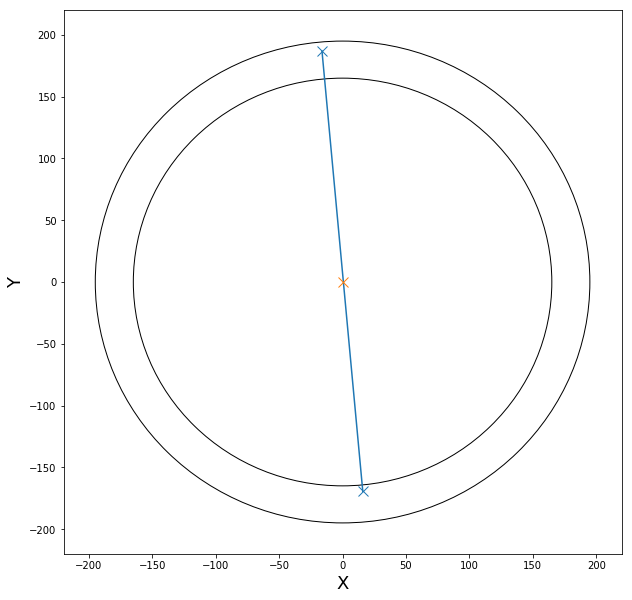

In [30]:
## Define the figure
fig = plt.figure(figsize=(10,10))
plt.xlim(-220, 220)
plt.ylim(-220, 220)
plt.xlabel('X', size=18)
plt.ylabel('Y', size=18)

## Define the ring
r_int = 165
r_ext = 195
center_point = (0., 0.)
circ1 = plt.Circle(center_point, r_int, color='k', fill=False)
circ2 = plt.Circle(center_point, r_ext, color='k', fill=False)

ax = fig.gca()
ax.add_artist(circ1)
ax.add_artist(circ2)

## Plot the sensors
plt.plot(a_xs, a_ys, 'x', markersize=10, linestyle='-')
plt.plot(0, 0, 'x', markersize=10)

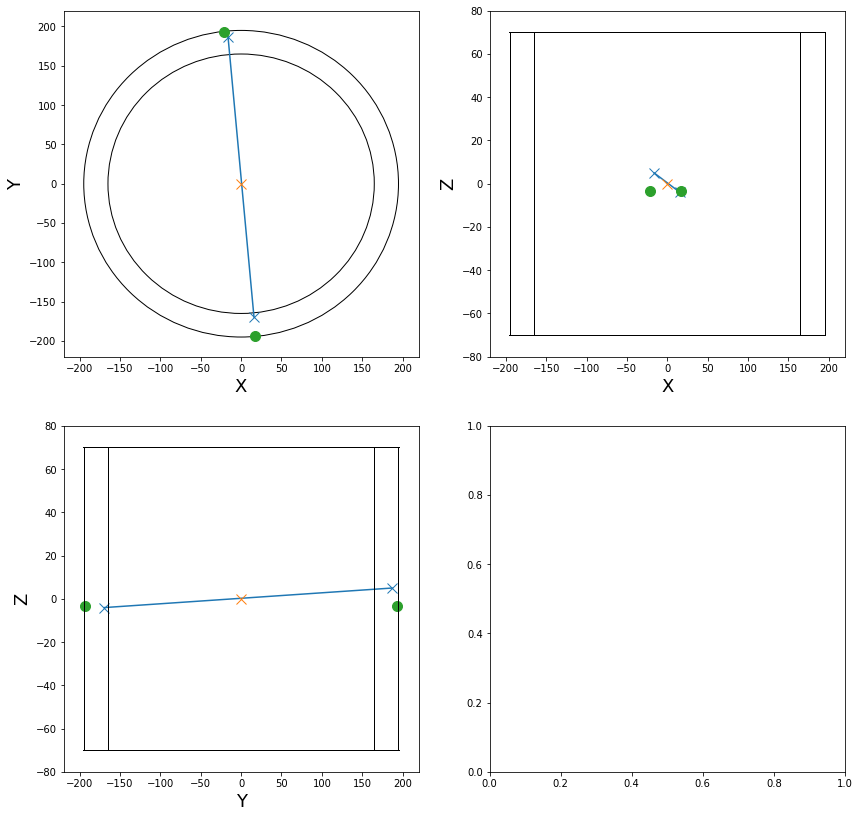

In [31]:
fig, axs = plt.subplots(2,2,figsize=(14,14))

## Define the figure
axs[0][0].set_xlim(-220, 220)
axs[0][0].set_ylim(-220, 220)
axs[0][0].set_xlabel('X', size=18)
axs[0][0].set_ylabel('Y', size=18)

axs[0][1].set_xlim(-220, 220)
axs[0][1].set_ylim(-80, 80)
axs[0][1].set_xlabel('X', size=18)
axs[0][1].set_ylabel('Z', size=18)

axs[1][0].set_xlim(-220, 220)
axs[1][0].set_ylim(-80, 80)
axs[1][0].set_xlabel('Y', size=18)
axs[1][0].set_ylabel('Z', size=18)

## Define the ring
r_int = 165
r_ext = 195
center_point = (0., 0.)
circ1 = plt.Circle(center_point, r_int, color='k', fill=False)
circ2 = plt.Circle(center_point, r_ext, color='k', fill=False)

#ax = fig.gca()
axs[0][0].add_artist(circ1)
axs[0][0].add_artist(circ2)

## Plot the sensors
axs[0][0].plot(a_xs, a_ys, 'x', markersize=10, linestyle='-')
axs[0][0].plot(0, 0, 'x', markersize=10)
axs[0][0].plot(a_sns_xs, a_sns_ys, 'o', markersize=10)
axs[0][1].plot(a_xs, a_zs, 'x', markersize=10, linestyle='-')
axs[0][1].plot(0, 0, 'x', markersize=10)
axs[0][1].plot(a_sns_xs, a_sns_zs, 'o', markersize=10)
axs[1][0].plot(a_ys, a_zs, 'x', markersize=10, linestyle='-')
axs[1][0].plot(0, 0, 'x', markersize=10)
axs[1][0].plot(a_sns_ys, a_sns_zs, 'o', markersize=10)

vlines = [-195, -165, 165, 195]
for v in vlines:
    axs[0][1].axvline(v, color='k', linewidth=1, ymin=0.065, ymax=0.935)
    axs[1][0].axvline(v, color='k', linewidth=1, ymin=0.065, ymax=0.935)
hlines = [-70, 70]
for h in hlines:
    axs[0][1].axhline(h, color='k', linewidth=1, xmin=0.055, xmax=0.945)
    axs[1][0].axhline(h, color='k', linewidth=1, xmin=0.055, xmax=0.945)
    


### Analysis data

In [2]:
eventsPath = '/data5/users/carmenromo/PETALO/PETit/PETit-ring/Christoff_sim/compton/analysis/data_CRT_0.0.0_phot/'

time_diff1 = []
time_diff2 = []
time_diff3 = []
time_diff4 = []
pos_cart1  = []
pos_cart2  = []

for filename in os.listdir(eventsPath):
    if filename.endswith('.npz'):
        my_file = eventsPath+filename        
        d = np.load(my_file)
        #print(d.items())
                        
        #sel = (d['time_diff'] != 0)
        for i in d['time_diff1']:
            time_diff1.append(i)
        for i in d['time_diff2']:
            time_diff2.append(i)
        for i in d['time_diff3']:
            time_diff3.append(i)
        for i in d['time_diff4']:
            time_diff4.append(i)
        for i in d['pos_cart1']:
            pos_cart1.append(i)
        for i in d['pos_cart2']:
            pos_cart2.append(i)
            
a_time_diff1 = np.array(time_diff1)
a_time_diff2 = np.array(time_diff2)
a_time_diff3 = np.array(time_diff3)
a_time_diff4 = np.array(time_diff4)
a_pos_cart1  = np.array(pos_cart1 )
a_pos_cart2  = np.array(pos_cart2 )

In [3]:
len(a_time_diff1)

31121

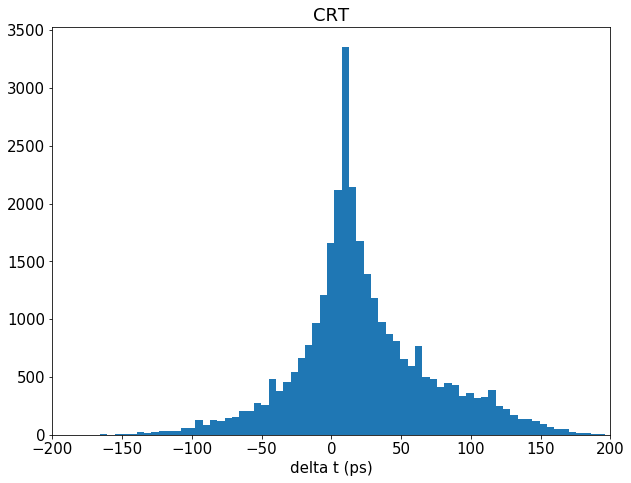

In [11]:
plt.rcParams["font.size"]      = 15
plt.rcParams["figure.figsize"] = 10, 7.5

plt.hist(a_time_diff2, bins=80)
plt.xlim(-200, 200)
plt.title('CRT')
plt.xlabel('delta t (ps)')
plt.show()

In [17]:
def get_weights(data):
    return np.repeat(1.0/len(data), len(data))

## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue       = tableau20[ 0]
orange     = tableau20[ 2]
green      = tableau20[ 4]
fucsia     = tableau20[ 6]
purple     = tableau20[ 8]
rosita     = tableau20[12]
caqui      = tableau20[16]
light_blue = tableau20[18]

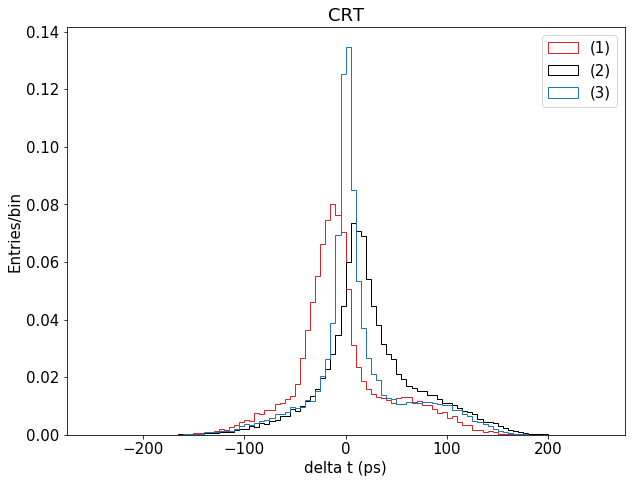

In [18]:
plt.rcParams["font.size"]      = 15
plt.rcParams["figure.figsize"] = 10, 7.5

fig = plt.figure(1)
fig.set_figwidth(10.)
fig.set_figheight(7.5)

plot_range = (-250, 250)

bins = np.histogram(np.hstack((a_time_diff1, a_time_diff2, a_time_diff3, a_time_diff4)), 
                    bins=100, range=plot_range)[1] #get the bin edges
weights0  = get_weights(a_time_diff1)
weights1  = get_weights(a_time_diff2)
weights2  = get_weights(a_time_diff3)
weights3  = get_weights(a_time_diff4)

plt.title ('CRT')
plt.xlabel('delta t (ps)')
plt.ylabel('Entries/bin' )
h1 = plt.hist(a_time_diff1, bins=bins, weights=weights0, color=fucsia, histtype='step', 
              stacked=True, fill=False, label='(1)', linewidth=1)
h2 = plt.hist(a_time_diff2, bins=bins, weights=weights1, color='k', histtype='step', 
              stacked=True, fill=False, label='(2)', linewidth=1,)
h3 = plt.hist(a_time_diff3, bins=bins, weights=weights2, color=blue, histtype='step', 
              stacked=True, fill=False, label='(3)', linewidth=1)
#h4 = plt.hist(a_time_diff4, bins=bins, weights=weights3, color=rosita, histtype='step', 
#              stacked=True, fill=False, label='(4)', linewidth=1)
plt.legend()
#plt.savefig('energy_raw_corrected_p4mm.png')

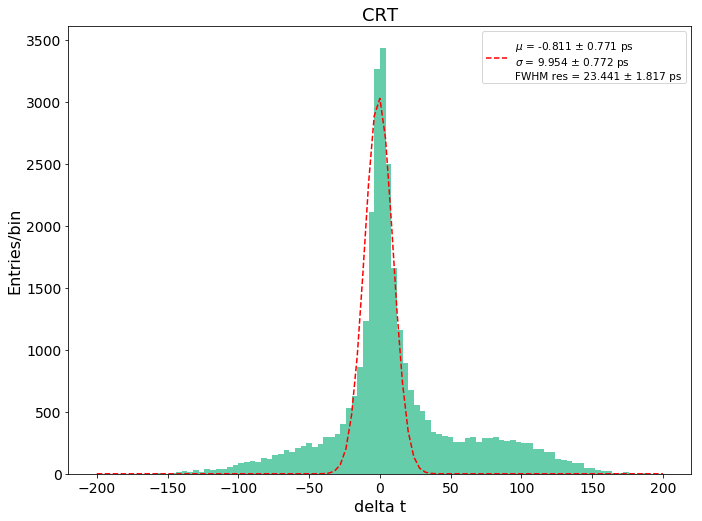

In [19]:
y, x, _   = plt.hist(a_time_diff3, 100, (-200, 200), facecolor='mediumaquamarine')

mu, sigma = norm.fit(a_time_diff3)
f         = fitf.fit(fitf.gauss, x[:-1], y, (50,mu,sigma), fit_range=(-30, 50))
fwhm      = 2.35482 * (np.sqrt(np.var(a_time_diff3)))

mu2        = f.values[1]
mu2_err    = f.errors[1]
sigma2     = f.values[2]
sigma2_err = f.errors[2]
fwhm2      = sigma2      * 2.355
fwhm2_err  = sigma2_err  * 2.355
chi2       = f.chi2

plt.plot(x, fitf.gauss(x, *f.values[ :3]), "r--", 
         label='$\mu$ = %.3f ± %.3f ps \n$\sigma$ = %.3f ± %.3f ps \nFWHM res = %.3f ± %.3f ps'% 
         (mu2, mu2_err, sigma2, sigma2_err, fwhm2, fwhm2_err))
plt.title ('CRT', fontsize=18)
plt.ylabel('Entries/bin', fontsize=16)
plt.xlabel('delta t', fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=10.5, loc=1)

plt.tight_layout()

### Calculation of the CRT having into account the depth of interaction of the gammas:

In [25]:
idssss2 = []

for number in range(start, start+numb):
    number_str = "{:03d}".format(number)
    filename  = f"{eventsPath}/{file_name}.{number_str}.pet.h5"
    try:
        print('Trying file {0}'.format(filename))
        h5in = tb.open_file(filename, mode='r')
    except ValueError:
        continue
    except OSError:
         continue
    print('Analyzing file {0}'.format(filename))

    h5extents      = h5in.root.MC.extents
    events_in_file = len(h5extents)
    
    sens_pos       = rf.sensor_position    (h5in)
    sens_pos_cyl   = rf.sensor_position_cyl(h5in)
    bin_width      = read_SiPM_bin_width_from_conf(h5in)

    charge_range = (1000, 1400)

    phot_evts = [222, 2502, 4678]

    for evt in phot_evts:
    #for evt in range(events_in_file):
        ave_true1, ave_true2 = rf.true_photoelect(h5in, filename, evt, compton=False)
        if len(ave_true1)==0 or len(ave_true2)==0:
            continue
            
        event_number       = h5in.root.MC.extents[evt]['evt_number']
        this_event_wvf     = go_through_file(h5in, h5in.root.MC.waveforms, (evt, evt+1), bin_width, 'data')
        this_event_wvf_tof = read_mcTOFsns_response(filename, (evt, evt+1))

        sns_over_thr, charges_over_thr = rf.find_SiPMs_over_threshold(this_event_wvf, e_threshold)

        if len(charges_over_thr) == 0: continue

        this_event_dict = read_mcinfo(h5in, (evt, evt+1))
        part_dict       = list(this_event_dict.values())[0]
        i1, i2, pos_true1, pos_true2, _, _, ids1, ids2, q1, q2, pos1, pos2 = rf.select_true_pos_from_charge(sns_over_thr, 
                                                                                                charges_over_thr, 
                                                                                                charge_range, 
                                                                                                sens_pos, part_dict)
        
        idssss2.append(ids2)
        if i1 and i2:
            print(evt)
            positions1, qs1 = rf.reco_pos_single(pos_true1, np.array(q1), np.array(pos1), 
                                                  rpos_threshold, phi_threshold, zpos_threshold)
            positions2, qs2 = rf.reco_pos_single(pos_true2, np.array(q2), np.array(pos2), 
                                                  rpos_threshold, phi_threshold, zpos_threshold)

            if len(positions1) == 0 or len(positions2) == 0:
                continue
            
            phi1s       = ats.from_cartesian_to_cyl(positions1[0])[:,1]
            var_phi1    = rf.get_var_phi(phi1s, qs1[0])
            sigma_phi1  = np.sqrt(var_phi1)
            r1          = Rpos(sigma_phi1).value

            phi2s       = ats.from_cartesian_to_cyl(positions2[0])[:,1]
            var_phi2    = rf.get_var_phi(phi2s, qs2[0])
            sigma_phi2  = np.sqrt(var_phi2)
            r2          = Rpos(sigma_phi2).value

            reco_cart = ats.barycenter_3D(positions1[1], qs1[1])
            phi1      = np.arctan2(reco_cart[1], reco_cart[0])

            reco_cart = ats.barycenter_3D(positions2[1], qs2[1])
            phi2      = np.arctan2(reco_cart[1], reco_cart[0])

            reco_cart = ats.barycenter_3D(positions1[2], qs1[2])
            z1        = reco_cart[2]

            reco_cart = ats.barycenter_3D(positions2[2], qs2[2])
            z2        = reco_cart[2]
            
            pos1_cart = []
            pos2_cart = []
            if r1 and phi1 and z1 and len(q1) and r2 and phi2 and z2 and len(q2):
                pos1_cart.append(r1 * np.cos(phi1))
                pos1_cart.append(r1 * np.sin(phi1))
                pos1_cart.append(z1)
                pos2_cart.append(r2 * np.cos(phi2))
                pos2_cart.append(r2 * np.sin(phi2))
                pos2_cart.append(z2)
            else: continue

            a_cart1 = np.array(pos1_cart)
            a_cart2 = np.array(pos2_cart)
                        
            sns_dict_tof = list(this_event_wvf_tof.values())[0]
            min_t1, min_id1 = rf.find_first_time_of_sensors(sns_dict_tof, ids1)
            min_t2, min_id2 = rf.find_first_time_of_sensors(sns_dict_tof, ids2)
            
            min_t1 = min_t1/0.001 #from ns to ps
            min_t2 = min_t2/0.001


            ### Distance between interaction point and sensor detecting first photon                                                                                              
            dp1 = np.linalg.norm(np.subtract(a_cart1, sens_pos[-min_id1]))
            dp2 = np.linalg.norm(np.subtract(a_cart2, sens_pos[-min_id2]))
            
            geo_center = np.array([0,0,0])
            dg1 = np.linalg.norm(a_cart1 - geo_center)
            dg2 = np.linalg.norm(a_cart2 - geo_center)
            
            delta_t1 = 1/2 *(min_t2 - min_t1 + (dp1 - dp2)/ave_speed_in_LXe)
            delta_t2 = 1/2 *(min_t2 - min_t1)
            delta_t3 = 1/2 *(min_t2 - min_t1 + (dp1 - dp2)/ave_speed_in_LXe + (dg1 - dg2)/speed_in_vacuum)


            ### CRT calculation having into account the depth of interaction of the gammas                                                                                        
            point_a, point_b = intersect_points_line_and_circ(a_cart1, a_cart2, r_int)
            #print(point_a, point_b)
            #print(pos1_cart, pos2_cart)
            #print(a_cart1, a_cart2)
            half_ab = (point_a + point_b)/2

            da = np.linalg.norm(np.subtract(a_cart1, point_a))
            db = np.linalg.norm(np.subtract(a_cart2, point_b))
            #if da < db:
            #    db = np.linalg.norm(np.subtract(a_cart2, point_b))
            #else:
            #    da = np.linalg.norm(np.subtract(a_cart2, point_a))

            delta_t4 = 1/2 *(min_t2 - min_t1 + (dp1 - dp2)/ave_speed_in_LXe + (da - db)/ave_speed_in_LXe)
            print(delta_t1)
            print(delta_t2)
            print(delta_t3)
            print(delta_t4)
            print('')


Trying file /data5/users/carmenromo/PETALO/PETit/PETit-ring/Christoff_sim/compton/analysis/data_ring/full_ring_iradius165mm_z140mm_depth3cm_pitch7mm.010.pet.h5
Analyzing file /data5/users/carmenromo/PETALO/PETit/PETit-ring/Christoff_sim/compton/analysis/data_ring/full_ring_iradius165mm_z140mm_depth3cm_pitch7mm.010.pet.h5
222
-110.37522027142103
-57.5
-88.72245208390171
88.48062059410677

2502
127.13861090586505
157.5
156.27413049965634
161.0972599340969

4678
-35.249192739326276
40.0
1.8165395657620493
-99.59725429633825



In [12]:
def intersect_points_line_and_circ(p1_line, p2_line, r_circ):
    x1, y1, z1 = p1_line
    x2, y2, z2 = p2_line
    m = (y2 - y1)/(x2 - x1)
    xa = (x1*m*m - m*y1 - np.sqrt(r_circ*r_circ*(m*m+1) - x1*x1*m*m - y1*y1 + 2*x1*y1*m)) / (m*m+1)
    xb = (x1*m*m - m*y1 + np.sqrt(r_circ*r_circ*(m*m+1) - x1*x1*m*m - y1*y1 + 2*x1*y1*m)) / (m*m+1)
    
    ya = m * (xa-x1) + y1
    yb = m * (xb-x1) + y1
    
    m2 = (z2-z1)/(x2-x1)
    za = m2*(-r_circ-x1) + z1
    zb = m2*( r_circ-x2) + z1
    
    d1 = np.linalg.norm(np.subtract(p1_line, np.array([xa, ya, za])))
    d2 = np.linalg.norm(np.subtract(p1_line, np.array([xb, yb, zb])))
    if d1 < d2:
        return np.array([xa, ya, za]), np.array([xb, yb, zb])
    else:
        return np.array([xb, yb, zb]), np.array([xa, ya, za])

In [48]:
poss_x = []
poss_y = []
for ids in idssss2[0]:
    poss_x.append(sens_pos[ids][0])
    poss_y.append(sens_pos[ids][1])

[ 2.49711850e-02  7.08812260e-01 -4.39257175e+01]


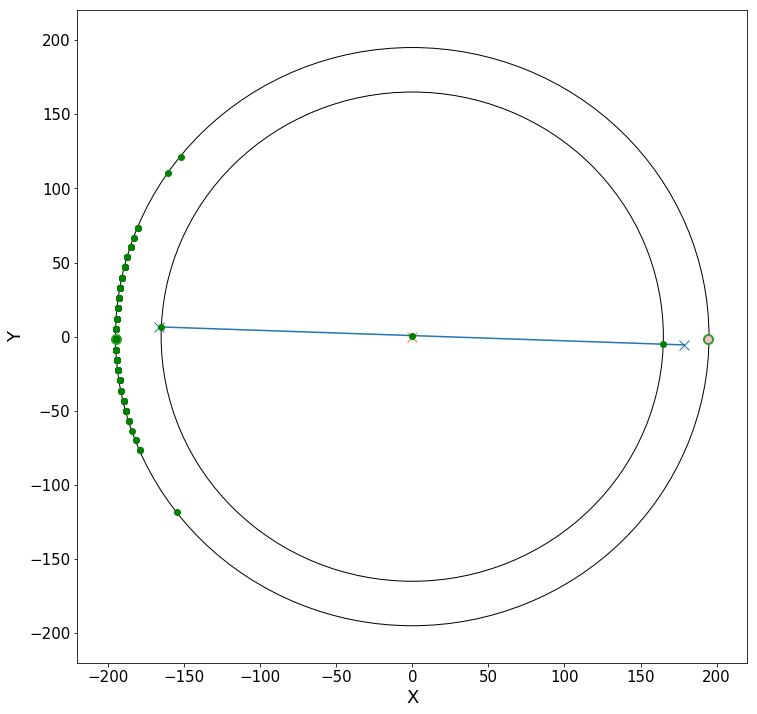

In [49]:
## Define the figure
fig = plt.figure(figsize=(12,12))
plt.xlim(-220, 220)
plt.ylim(-220, 220)
plt.xlabel('X', size=18)
plt.ylabel('Y', size=18)

## Define the ring
r_int = 165
r_ext = 195
center_point = (0., 0.)
circ1 = plt.Circle(center_point, r_int, color='k', fill=False)
circ2 = plt.Circle(center_point, r_ext, color='k', fill=False)

ax = fig.gca()
ax.add_artist(circ1)
ax.add_artist(circ2)


A_pos = np.array([164.92115017, -5.10041439, -129.31550923])
B_pos = np.array([-164.8712078, 6.51803891, 41.46407428])
half_ab = (A_pos + B_pos)/2
print(half_ab)
## Reco pos
plt.plot(a_xs, a_ys, 'x', markersize=10, linestyle='-')
plt.plot(0, 0, 'x', markersize=10)
plt.plot(A_pos[0], A_pos[1], 'o', color='g')
plt.plot(B_pos[0], B_pos[1], 'o', color='g')
plt.plot(half_ab[0], half_ab[1], 'o', color='g')
plt.plot(a_sns_xs, a_sns_ys, 'o', markersize=10)
plt.plot(np.array(poss_x), np.array(poss_y), 'o', color='g')
plt.plot(sens_pos[1656][0], sens_pos[1656][1], 'o', color='pink')

In [ ]:
def reco_pos_single(true_pos, sns_q, sns_pos, th_r, th_phi, th_z):
    list_thrs = [th_r, th_phi, th_z]
    positions = []
    qs        = []
    for th in list_thrs:
        indices_over_thr = sns_q > th
        pos_over_thr     = sns_pos[indices_over_thr]
        charges_over_thr = sns_q  [indices_over_thr]
        if len(charges_over_thr) == 0:
            return [], []

        positions.append(np.array(pos_over_thr))
        qs       .append(np.array(charges_over_thr))

    return positions, qs